In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [2]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/Users/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc', autoclose=True)
end = time.time()
print(end - start)

12.5017530918


# Define functions in package:

# Clustering for DWT

In [4]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [5]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

In [96]:
def wavelet_levels(data_set, level_time, level_space, wavelet_time, wavelet_space):
    '''
    The following code computes the DWT in space-time.  The space is computed using the wavelet_space, time is wavelet_time.  The level of the transformation for space and time are 
    level_space and level_time respectively. The data for LOCA has space as [1,2].
    '''
    
    wp = pywt.wavedecn(data=data_set, wavelet = wavelet_space, level = level_space, axes = [1,2])
    wp = pywt.wavedecn(data=wp[0], wavelet = wavelet_time, level = level_time, axes = [0])
    
    return wp

In [248]:
#Function to compute single level for feature data
def single_level_class(data_set, level_time, level_space, wavelet_time = 'haar', wavelet_space='haar', n_clusters=3):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    print("Level Space: " + str(level_space))
    print("Level Time: " + str(level_time))    

    
    #Compute DWT in space.  Note that we don't need any DWT coef. other than approximation at each level.
    start = time.time()
    wp = wavelet_levels(data_set, level_time, level_space, wavelet_time, wavelet_space)
    
    
    #Reshape the data for DBScan
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    data = np.transpose(shaped)
    print(data.shape)
    
    end = time.time()
    diff = str(end-start)
    print("Wavelet and Prep Data:" + diff)
    
    
    start = time.time() #for clustering
    ########################################################################
    # Perform DBSCAN to discover classes
    # Added parameters:
    # metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001
    ########################################################################
    
    
    #Discover the epsilon for DBScan using knn. 
    #start = time.time()
    #nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    #distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    #epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    #print("Epsilon Value:" + str(epsilon))
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    #min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    #end = time.time()
    #diff = str(end-start)
    #print("Find Params:" + diff)
    
    #Perform db scan and return the result
    #start = time.time()
    #classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    #end = time.time()
    #diff = str(end-start)
    #print("DBSCAN:" + diff)
    
    #####################################
    # Perform K-means to discover classes
    # Added parameters:
    # n_clusters
    #####################################
    
    #Peform K-means
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    classes = kmeans.labels_
    
    end = time.time()
    diff = str(end-start)
    print("Clustering:" + diff)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    

    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

# Index maps to return labels to initial data

In [7]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [8]:
#Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
def dwt_length(data, wavelet):
    
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wavelet).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wavelet).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [9]:
def middle_match(data_len,wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((float(data_len)-w_len)/2))
    
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [11]:
def top_match(data_len, wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [12]:
def bot_match(data_len, wavelet):
   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    
    
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [13]:
#Function used to build filter matrix for mapping classes back one level
def filter_matrix(data_len, wavelet):
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [14]:
#Function used to discover classes at one stage higher resolution
def map_back_index(wavelet, dwt_lengths, max_level):
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

# Having clustered, we now map each class back to initial data

In [15]:
def map_back_classes(data_classes, index_up_lat, index_up_lon, max_level):
    
    final_class = []
    for j in range(max_level):
        classt = data_classes[j]
        for i in range(j+1):
            classt = classt[index_up_lat[j-i]][:,index_up_lon[j-i]]
        final_class.append(classt)
        
    return final_class

# Test Algorithm on Data:

# Prepare data for processing

In [312]:
ds

<xarray.Dataset>
Dimensions:  (lat: 614, lon: 928, time: 768)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 -124.7 -124.7 -124.6 ...
  * lat      (lat) float64 14.66 14.72 14.78 14.84 14.91 14.97 15.03 15.09 ...
  * time     (time) datetime64[ns] 1950-01-16 1950-02-14T12:00:00 1950-03-16 ...
Data variables:
    Prec     (time, lat, lon) float32 dask.array<shape=(768, 614, 928), chunksize=(1, 614, 928)>
    Tmax     (time, lat, lon) float32 dask.array<shape=(768, 614, 928), chunksize=(1, 614, 928)>
    Tmin     (time, lat, lon) float32 dask.array<shape=(768, 614, 928), chunksize=(1, 614, 928)>
    wind     (time, lat, lon) float32 dask.array<shape=(768, 614, 928), chunksize=(1, 614, 928)>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    Conventions:               CF-1.4
    history:                   Wed Jun 10 08:23:22 2015: ncra -O /export/ftp/...
    nco_openmp_thread_number:  1
    NCO:                       4.4.5

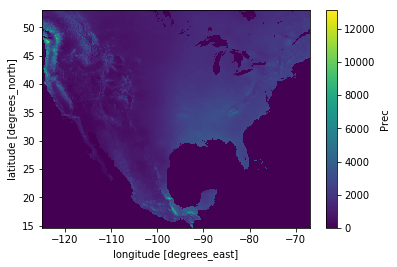

In [311]:
ds.Prec.sum('time').plot()

In [319]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
#ds2 = ds.isel(lat=slice(250, 550), lon=slice(0, 800), time=slice(0, 200))
#ds2.Prec.sum('time').plot()
ds2 = ds

In [320]:
#Create a small amount of noise to perturb the data by.  The idea is to make values of zero close (but not equal to) zero.
noise = da.random.normal(0, scale = 1/(1000000), size = (ds2.time.size, ds2.lat.size, ds2.lon.size), chunks = (1,ds2.lat.size, ds2.lon.size) )

In [321]:
data = ds2+noise

In [322]:
#Prec data
mean = np.array(ds2.Prec.mean())
data_Prec = da.nan_to_num(data.Prec.data)
data_Prec
data_Prec[data_Prec==0] = mean

In [323]:
#Tmax data
mean = np.array(ds2.Tmax.mean())
data_Tmax = da.nan_to_num(data.Tmax.data)
data_Tmax
data_Tmax[data_Tmax==0] = mean

In [324]:
#Tmin data
mean = np.array(ds2.Tmin.mean())
data_Tmin = da.nan_to_num(data.Tmin.data)
data_Tmin
data_Tmin[data_Tmin==0] = mean

# Set up Wavelet Transform

In [164]:
#pywt.wavelist()
#Information : http://wavelets.pybytes.com/
#print(pywt.Wavelet('haar'))

In [325]:
#Set the number of levels for DWT, as well as the wavelet

#First, the time information:
wave_time = 'db2'
max_level_time = pywt.dwt_max_level(data_len = ds2.time.size, filter_len = pywt.Wavelet(wave_time).dec_len) 

#Next, space information:
wave_space = 'haar'
max_level_lat= pywt.dwt_max_level(data_len = ds2.lat.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
max_level_lon= pywt.dwt_max_level(data_len = ds2.lon.size, filter_len = pywt.Wavelet(wave_space).dec_len) 


max_level= min(max_level_lat, max_level_lon, max_level_time)

In [326]:
max_level

8

In [327]:
#In order to invert the DWT classifier, need lengths for lat, lon, time:

#dwt_lengths_time = dwt_length(ds2.time, wave_time)
dwt_lengths_lat = dwt_length(ds2.lat, wave_space)
dwt_lengths_lon = dwt_length(ds2.lon, wave_space)

#index_up_time = map_back_index(wave_time,dwt_lengths_time,max_level_time)
index_up_lat = map_back_index(wave_space,dwt_lengths_lat,max_level_lat)
index_up_lon = map_back_index(wave_space,dwt_lengths_lon,max_level_lon)

In [328]:
#Build a nan-mask to be used on data sets once classified:
nan_mask = np.isnan(ds2.Prec.data[0])
nan_mask = np.array(nan_mask)
nan_mask = nan_mask*np.array(ds2.Prec.data[0])

# Test on climate data

# Prec Classes:

In [329]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(data_Prec, wavelet_space = wave_space, wavelet_time = wave_time, level_space = i, level_time = 2, n_clusters = 4)
    Prec_classes.append(classes)

Level Space: 1
Level Time: 2
(142448, 194)
Wavelet and Prep Data:47.0625100136
Clustering:14.4265081882
TOTAL: 61.4896309376

Level Space: 2
Level Time: 2
(35728, 194)
Wavelet and Prep Data:44.3902540207
Clustering:3.68066000938
TOTAL: 48.0718209743

Level Space: 3
Level Time: 2
(8932, 194)
Wavelet and Prep Data:43.5980129242
Clustering:0.696395874023
TOTAL: 44.2949368954

Level Space: 4
Level Time: 2
(2262, 194)
Wavelet and Prep Data:43.7209048271
Clustering:0.194532871246
TOTAL: 43.9171998501

Level Space: 5
Level Time: 2
(580, 194)
Wavelet and Prep Data:43.8257758617
Clustering:0.0860230922699
TOTAL: 43.9131879807

Level Space: 6
Level Time: 2
(150, 194)
Wavelet and Prep Data:43.6334531307
Clustering:0.0470840930939
TOTAL: 43.6813428402

Level Space: 7
Level Time: 2
(40, 194)
Wavelet and Prep Data:43.8152339458
Clustering:0.0289099216461
TOTAL: 43.8449039459

Level Space: 8
Level Time: 2
(12, 194)
Wavelet and Prep Data:43.5375621319
Clustering:0.0210530757904
TOTAL: 43.5591659546



In [330]:
Prec_classes_f = map_back_classes(Prec_classes, index_up_lat, index_up_lon, max_level)
for i in range(max_level):
    Prec_classes_f[i] = Prec_classes_f[i]+nan_mask

# Tmax Classes:

In [331]:
#Gather all the Prec classes for each level:
%reset_selective -f Tmax_classes

Tmax_classes = []
for i in range(1, max_level+1):
    classes = single_level_class(data_Tmax, wavelet_space = wave_space, wavelet_time = wave_time, level_space = i, level_time = 2, n_clusters =4)
    Tmax_classes.append(classes)

Level Space: 1
Level Time: 2
(142448, 194)
Wavelet and Prep Data:47.6245539188
Clustering:14.7849590778
TOTAL: 62.4108600616

Level Space: 2
Level Time: 2
(35728, 194)
Wavelet and Prep Data:44.3251438141
Clustering:2.94055008888
TOTAL: 47.267029047

Level Space: 3
Level Time: 2
(8932, 194)
Wavelet and Prep Data:43.8276731968
Clustering:0.655605077744
TOTAL: 44.4836890697

Level Space: 4
Level Time: 2
(2262, 194)
Wavelet and Prep Data:44.2907230854
Clustering:0.207589864731
TOTAL: 44.4998018742

Level Space: 5
Level Time: 2
(580, 194)
Wavelet and Prep Data:43.7373609543
Clustering:0.0722901821136
TOTAL: 43.8104710579

Level Space: 6
Level Time: 2
(150, 194)
Wavelet and Prep Data:43.6085090637
Clustering:0.0405662059784
TOTAL: 43.6501789093

Level Space: 7
Level Time: 2
(40, 194)
Wavelet and Prep Data:43.6309361458
Clustering:0.0226039886475
TOTAL: 43.6547780037

Level Space: 8
Level Time: 2
(12, 194)
Wavelet and Prep Data:43.9065740108
Clustering:0.0200929641724
TOTAL: 43.9269230366



In [332]:
Tmax_classes_f = map_back_classes(Tmax_classes, index_up_lat, index_up_lon, max_level)
for i in range(max_level):
    Tmax_classes_f[i] = Tmax_classes_f[i]+nan_mask

# Tmin Classes

In [333]:
#Gather all the Prec classes for each level:
%reset_selective -f Tmin_classes

Tmin_classes = []
for i in range(1, max_level+1):
    classes = single_level_class(data_Tmin, wavelet_space = wave_space, wavelet_time = wave_time, level_space = i, level_time = 2, n_clusters = 4)
    Tmin_classes.append(classes)

Level Space: 1
Level Time: 2
(142448, 194)
Wavelet and Prep Data:47.9150371552
Clustering:15.6000180244
TOTAL: 63.5158479214

Level Space: 2
Level Time: 2
(35728, 194)
Wavelet and Prep Data:44.4573719501
Clustering:3.42009687424
TOTAL: 47.8788869381

Level Space: 3
Level Time: 2
(8932, 194)
Wavelet and Prep Data:44.6600317955
Clustering:0.827073812485
TOTAL: 45.4874811172

Level Space: 4
Level Time: 2
(2262, 194)
Wavelet and Prep Data:43.746557951
Clustering:0.241755008698
TOTAL: 43.9892590046

Level Space: 5
Level Time: 2
(580, 194)
Wavelet and Prep Data:43.6404349804
Clustering:0.0864059925079
TOTAL: 43.7275350094

Level Space: 6
Level Time: 2
(150, 194)
Wavelet and Prep Data:43.6939930916
Clustering:0.0548169612885
TOTAL: 43.7494521141

Level Space: 7
Level Time: 2
(40, 194)
Wavelet and Prep Data:44.0877730846
Clustering:0.0250890254974
TOTAL: 44.1139168739

Level Space: 8
Level Time: 2
(12, 194)
Wavelet and Prep Data:43.768294096
Clustering:0.020416021347
TOTAL: 43.7889959812



In [334]:
Tmin_classes_f = map_back_classes(Tmin_classes, index_up_lat, index_up_lon, max_level)
for i in range(max_level):
    Tmin_classes_f[i] = Tmin_classes_f[i]+nan_mask

# Plot Results

In [335]:
lat_space = np.linspace(start = np.min(ds2.lat.data), stop = np.max(ds2.lat.data), num = 7)
lat_space = np.round(lat_space, decimals = 1)
lon_space = np.linspace(start = np.min(ds2.lon.data), stop = np.max(ds2.lon.data), num = 7)
lon_space = np.round(lon_space, decimals = 1)

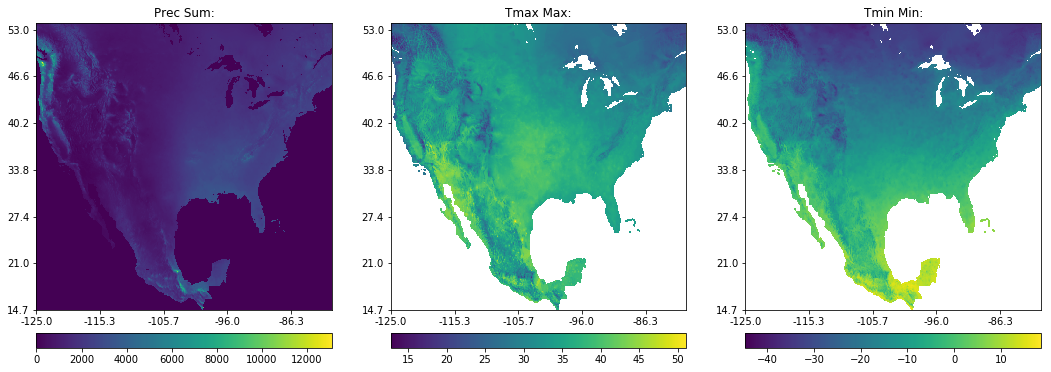

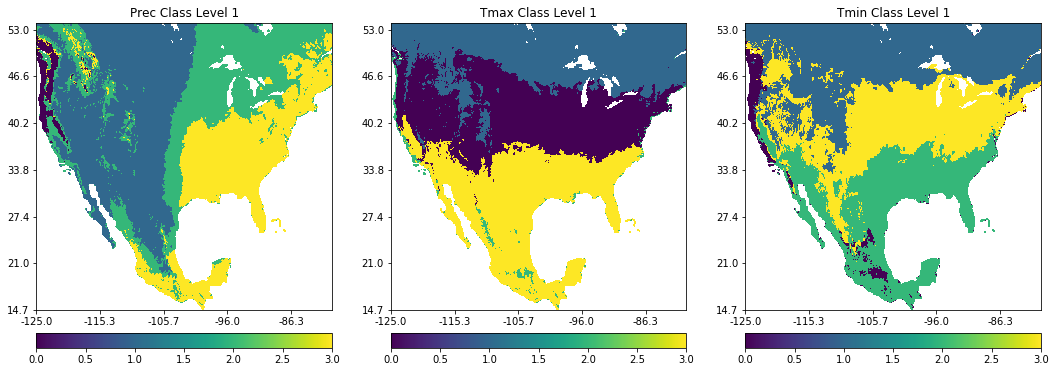

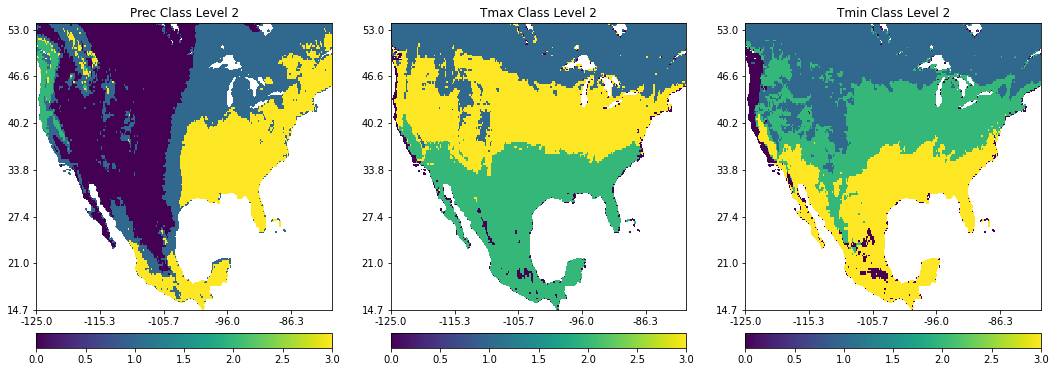

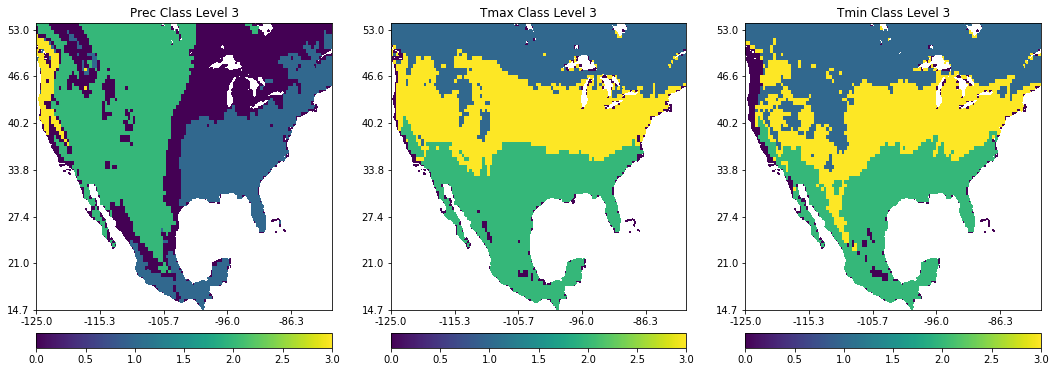

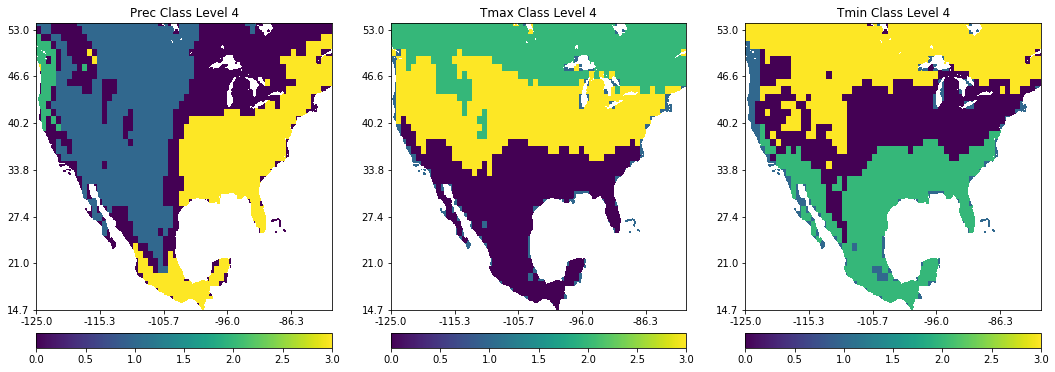

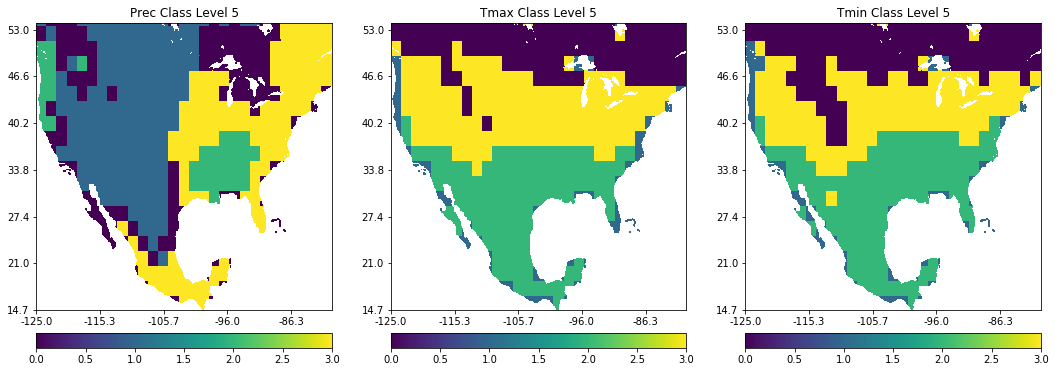

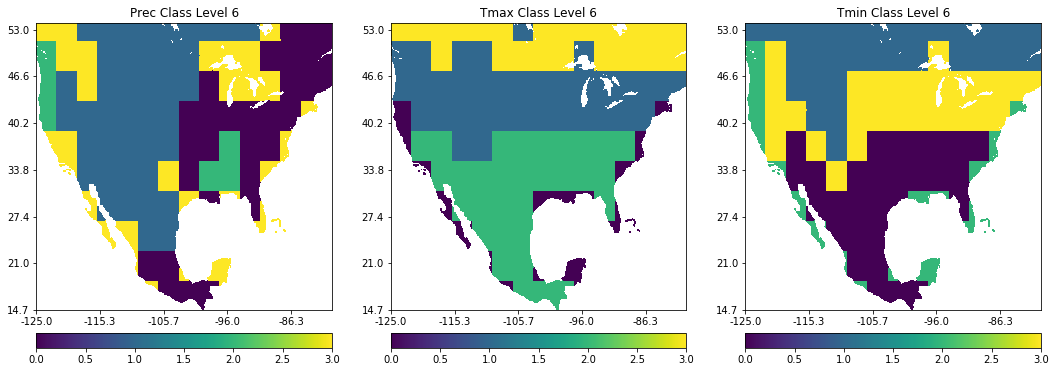

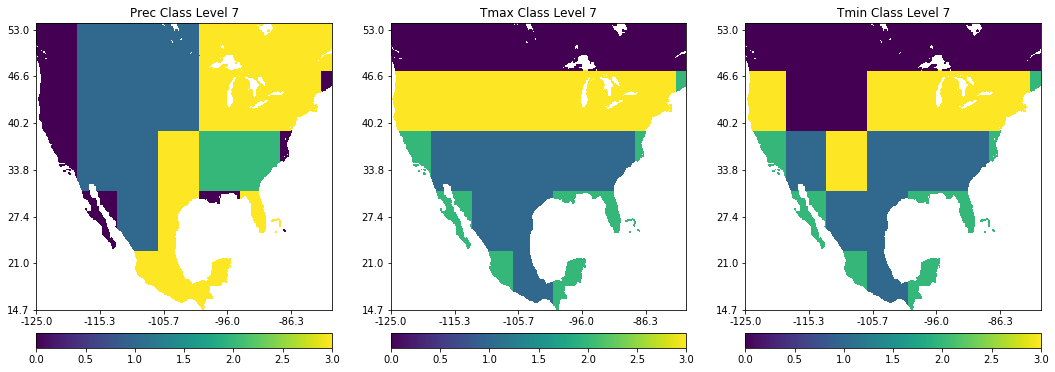

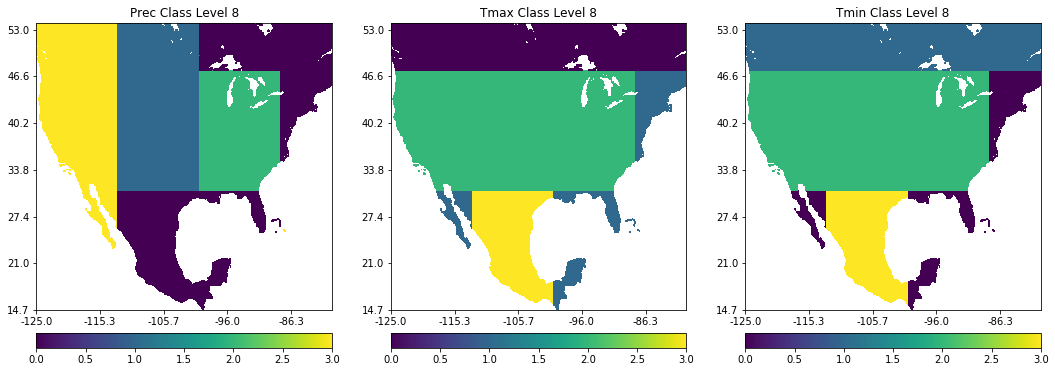

<Figure size 432x288 with 0 Axes>

In [336]:
#######
#Means#
#######
plt.figure(-1)
f, ax = plt.subplots(figsize=(18, 6), ncols=3, nrows=1)
#Plot Prec
p0= ax[0].pcolormesh(ds2.Prec.sum('time').data)
plt.colorbar(p0, ax=ax[0], orientation='horizontal',
             pad=0.07, fraction=0.05)
ax[0].set_title('Prec Sum:')

ax[0].set_xticklabels(lon_space, minor=False)
ax[0].set_yticklabels(lat_space, minor=False)
#Plot Tmax
p1= ax[1].pcolormesh(ds2.Tmax.max('time').data)
plt.colorbar(p1, ax=ax[1], orientation='horizontal',
             pad=0.07, fraction=0.05)
ax[1].set_title('Tmax Max:')

ax[1].set_xticklabels(lon_space, minor=False)
ax[1].set_yticklabels(lat_space, minor=False)
#Plot Tmin
p2= ax[2].pcolormesh(ds2.Tmin.min('time').data)
plt.colorbar(p2, ax=ax[2], orientation='horizontal',
             pad=0.07, fraction=0.05)
ax[2].set_title('Tmin Min:')

ax[2].set_xticklabels(lon_space, minor=False)
ax[2].set_yticklabels(lat_space, minor=False)
#########
#Classes#
#########
for i in range(0,max_level):
    plt.figure(i)
    f, ax = plt.subplots(figsize=(18, 6), ncols=3, nrows=1)
    #Plot Prec
    p0= ax[0].pcolormesh(Prec_classes_f[i])
    plt.colorbar(p0, ax=ax[0], orientation='horizontal',
             pad=0.07, fraction=0.05)
    ax[0].set_title('Prec Class Level ' + str(i+1))
    
    ax[0].set_xticklabels(lon_space, minor=False)
    ax[0].set_yticklabels(lat_space, minor=False)
    #Plot Tmax
    p1= ax[1].pcolormesh(Tmax_classes_f[i])
    plt.colorbar(p1, ax=ax[1], orientation='horizontal',
             pad=0.07, fraction=0.05)
    ax[1].set_title('Tmax Class Level ' + str(i+1))
    
    ax[1].set_xticklabels(lon_space, minor=False)
    ax[1].set_yticklabels(lat_space, minor=False)
    #Plot Tmin
    p2= ax[2].pcolormesh(Tmin_classes_f[i])
    plt.colorbar(p2, ax=ax[2], orientation='horizontal',
             pad=0.07, fraction=0.05)
    ax[2].set_title('Tmin Class Level ' + str(i+1))
    
    ax[2].set_xticklabels(lon_space, minor=False)
    ax[2].set_yticklabels(lat_space, minor=False)